# Подбор гиперпараметров для моделей логистическая регрессия и случайный лес

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_5/selection_model_hyperparameters.ipynb

## Оглавление
- [1. Описание задачи](#item_1)
- [2. Знакомство с данными](#item_2)
- [3. Подготовка данных](#item_3)
- [4. Использование логистической регрессии (LogisticRegression)](#item_4)
    - [4.1. Использование гиперпараметров по умолчанию](#item_4_1)
    - [4.2. Поиск гиперпараметров с помощью GridSearchCV](#item_4_2)
    - [4.3. Поиск гиперпараметров с помощью RandomizedSearchCV](#item_4_3)
    - [4.4. Поиск гиперпараметров с помощью Hyperopt](#item_4_4)
    - [4.5. Поиск гиперпараметров с помощью Optuna](#item_4_5)
- [5. Использование случайного леса (RandomForestClassifier)](#item_5)
    - [5.1. Использование гиперпараметров по умолчанию](#item_5_1)
    - [5.2. Поиск гиперпараметров с помощью GridSearchCV](#item_5_2)
    - [5.3. Поиск гиперпараметров с помощью RandomizedSearchCV](#item_5_3)
    - [5.4. Поиск гиперпараметров с помощью Hyperopt](#item_5_4)
    - [5.5. Поиск гиперпараметров с помощью Optuna](#item_5_5)
- [6. Выводы](#item_6)

## 1. Описание задачи <a id="item_1"></a>

Работа основана на данных из соревнования Kaggle: \
[Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец '**Activity**') \
по их химическому составу (столбцы **D1-D1776**).

Каждая строка представляет молекулу. 

- Первый столбец **Activity** содержит экспериментальные данные, \
описывающие фактический биологический ответ `[0, 1]`; 
- Остальные столбцы **D1-D1776** представляют собой молекулярные дескрипторы — \
это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, \
например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать $F_1$-score.

Обучим две модели: **логистическую регрессию** и **случайный лес**. \
И сделаем подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации \
(**GridSeachCV**, **RandomizedSearchCV**, **Hyperopt**, **Optuna**).\
Сделаем вывод по полученным результатам.

## 2. Знакомство с данными <a id="item_2"></a>

In [1]:
# Импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn.model_selection import (
    train_test_split, # сплитование выборки
    cross_validate, # для кроссвалидации
    cross_val_score, # для кроссвалидации
    StratifiedKFold, # для кроссвалидации
    GridSearchCV, # подбор гиперпараметров по сетке
    RandomizedSearchCV, # случайный подбор гиперпараметров
)    

from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn import metrics # метрики

# hp - включает набор методов для объявления пространства поиска гиперпараметров
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# Trials - используется для логирования результатов
from hyperopt import hp, fmin, tpe, Trials

import optuna

from comet_ml import Experiment # логирование экспериментов

%matplotlib inline

In [2]:
# Объект класса Experiment для логирования результатов эксперимента
experiment = Experiment(
    api_key='HqXoBmU5CDGw1F2dJlB5w2Vdv',
    project_name='predicting-biological-response',
    workspace='experiment0',
    log_code=True
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/experiment0/predicting-biological-response/74718b66e9ad4415a2e1ba68b63f2c59



In [3]:
# Загрузим данные
data = pd.read_csv('./data/train_sem_09_1.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.shape

(3751, 1777)

> Таблица содержит 1777 признаков (включая целевой) и 3751 строку.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


> Все столбцы числовые.

In [6]:
# Проверим наличие пропусков
data.isnull().sum().sort_values(ascending=False)

Activity    0
D1181       0
D1192       0
D1191       0
D1190       0
           ..
D589        0
D588        0
D587        0
D586        0
D1776       0
Length: 1777, dtype: int64

> Пропусков в данных нет.

In [7]:
# Посмотрим на максимальные значения по столбцам
data.max().sort_values(ascending=False)

Activity    1.000000
D1185       1.000000
D1196       1.000000
D1195       1.000000
D1194       1.000000
              ...   
D630        0.235294
D632        0.200000
D631        0.181818
D823        0.166667
D801        0.142857
Length: 1777, dtype: float64

In [8]:
# Посмотрим на минимальные значения по столбцам
data.min().sort_values()

Activity    0.000000
D1190       0.000000
D1189       0.000000
D1188       0.000000
D1187       0.000000
              ...   
D189        0.190762
D201        0.257565
D9          0.275590
D2          0.282128
D181        0.354010
Length: 1777, dtype: float64

> Значения всех стобцов находятся в промежутке `[0, 1]` \
Данные нормализованы.

In [9]:
# Посмотрим на распределение целевого признака
data['Activity'].value_counts(True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

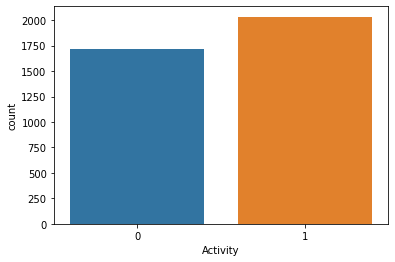

In [10]:
sns.countplot(data=data, x='Activity');

> Дисбаланс в целевой переменной не очень большой.

## 3. Подготовка данных <a id="item_3"></a>

Определим константы для дальнейшего использования.

In [11]:
# Имя колонки с целевой переменной
TARGET_NAME = 'Activity'
# Количество попыток для поиска лучших гиперпараметров
ATTEMPTS_COUNT = 20
# Для воспроизводимости результатов случайных вычислений
RANDOM_STATE = 42
# Максимальное количество итераций, выделенное на сходимость
MAX_ITER = 1000
# Количество фолдов для кросс-валидации
CV = 5
# Количество параллельных процессов (задаем -1, чтобы использовать все доступные ядра)
N_JOBS = -1

Создадим словарь, в который будем добавлять итоговые метрики.

In [12]:
metrics_results = {
    'model': ['LogisticRegression', 'RandomForestClassifier'],
    'defaultParams': [],
    'GridSearchCV': [],
    'RandomizedSearchCV': [],
    'Hyperopt': [],
    'Optuna': [],
}

Функции для дальнейшего использования.

In [13]:
def print_f1_score(f1_score, type='test'):
    """Печатает вывод метрики F1
    Args:
        f1_score (float): Значение метрики
        type (string): Тип выборки ('train' - тренировочная, 'test' - тестовая)
    """
    if (type == 'test'):
        print('f1_score на тестовом наборе: {:.2f}'.format(f1_score))
    elif (type == 'train'):
        print('f1_score на тренировочном наборе: {:.2f}'.format(f1_score))


def print_best_hyperparameters(best_params):
    """Печатает вывод лучших гиперпараметров
    Args:
        best_params (dict): Словарь с лучшими найденными гиперпараметрами модели
    """
    print('Наилучшие значения гиперпараметров {}'.format(best_params))

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [14]:
X = data.drop([TARGET_NAME], axis=1)
y = data[TARGET_NAME]

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. \
Для сохранения соотношений целевого признака используем параметр `stratify` (стратифицированное разбиение). 

In [15]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, random_state=RANDOM_STATE, test_size=0.2)

## 4. Использование логистической регрессии (LogisticRegression) <a id="item_4"></a>

### 4.1. Использование гиперпараметров по умолчанию <a id="item_4_1"></a>

In [16]:
# Создаем объект класса логистическая регрессия
model_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)

# Создаем объект кросс-валидатора k-fold со стратификацией
skf = StratifiedKFold(n_splits=CV, shuffle=False)

# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = cross_validate(
    estimator=model_lr, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

# Считаем средние метрики
f1_score_train = np.mean(cv_metrics['train_score'])
f1_score_test = np.mean(cv_metrics['test_score'])

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.89
f1_score на тестовом наборе: 0.78


In [17]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 LogisticRegression defaultParams', f1_score_test)

### 4.2. Поиск гиперпараметров с помощью GridSearchCV <a id="item_4_2"></a>

In [18]:
# Зададим сетку параметров
param_grid_lr = [
    {
        'penalty': ['l2', 'none'] , # тип регуляризации
        'solver': ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 50, 100, 200] # уровень силы регуляризации
    }, 
    {
        'penalty': ['l1', 'l2'] ,
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 50, 100, 200]
    }
]

# Создаем объект класса GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(
        random_state=RANDOM_STATE, # генератор случайных чисел
        max_iter=MAX_ITER # количество итераций на сходимость
    ), 
    param_grid=param_grid_lr, # сетка параметров
    scoring=metrics.make_scorer(metrics.f1_score), # метрика, которую улучшаем
    cv=CV, # количество фолдов для кросс валидации
    n_jobs=N_JOBS
)

In [19]:
# %time - замеряет время выполнения
%time 

# Обучаем
grid_search_lr.fit(X_train, y_train) 

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 50,
                                100, 200],
                          'penalty': ['l2', 'none'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 50,
                                100, 200],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             scoring=make_scorer(f1_score))

In [20]:
print_best_hyperparameters(grid_search_lr.best_params_)

Наилучшие значения гиперпараметров {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


In [21]:
# Метрика F1 на тренировочной выборке
f1_score_train = grid_search_lr.best_score_

# Считаем метрику F1 для тестовой выборки
f1_score_test = grid_search_lr.score(X_test, y_test)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.79
f1_score на тестовом наборе: 0.78


In [22]:
# Добавим значение метрики в словарь
metrics_results['GridSearchCV'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 LogisticRegression GridSearchCV', f1_score_test)

Посмотрим, как менялась метрика при различных гиперпараметрах.

{'web': 'https://www.comet.com/api/image/download?imageId=6a4add4b798a432cad0f67fd4ad3992d&experimentKey=74718b66e9ad4415a2e1ba68b63f2c59',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6a4add4b798a432cad0f67fd4ad3992d&experimentKey=74718b66e9ad4415a2e1ba68b63f2c59',
 'imageId': '6a4add4b798a432cad0f67fd4ad3992d'}

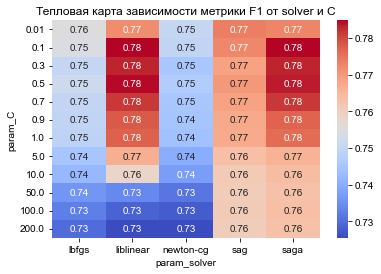

In [23]:
visual = pd.pivot_table(
        pd.DataFrame(grid_search_lr.cv_results_),
        values='mean_test_score',
        index='param_C',
        columns='param_solver'
    )

sns.heatmap(visual, annot=True, cmap='coolwarm')

# Подпись графика
plt.title('Тепловая карта зависимости метрики F1 от solver и С') 

# Размер графика
sns.set(rc={'figure.figsize': (18, 8)}) 

experiment.log_figure('F1 LogisticRegression GridSearchCV', plt)

> Можно сделать вывод, что наилучшие значения метрики $F_1$ наблюдались при \
`solver` равным  '`liblinear`' или '`saga`' и значениях `C` в промежутке `[0.1, 1]`.

### 4.3. Поиск гиперпараметров с помощью RandomizedSearchCV <a id="item_4_3"></a>

In [24]:
# Зададим варианты параметров
param_distributions_lr = [
    {
        'penalty': ['l2', 'none'] , # тип регуляризации
        'solver': ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 10, dtype=float)), # уровень силы регуляризации
    }, 
    {
        'penalty': ['l1', 'l2'] ,
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

# Создаем объект класса RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(
        random_state=RANDOM_STATE, # генератор случайных чисел 
        max_iter=MAX_ITER # количество итераций на сходимость
    ), 
    param_distributions=param_distributions_lr, # варианты параметров
    scoring=metrics.make_scorer(metrics.f1_score), # метрика, которую улучшаем
    cv=CV, # количество фолдов для кросс валидации
    n_iter=ATTEMPTS_COUNT, # количество комбинаций на расчет
    n_jobs=N_JOBS
)

In [25]:
# %time - замеряет время выполнения
%time 

# Обучаем
random_search_lr.fit(X_train, y_train) 

CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\exper\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions=[{'C': [0.01, 0.12, 0.23, 0.34, 0.45,
                                               0.56, 0.67, 0.78, 0.89, 1.0],
                                         'penalty': ['l2', 'none'],
                                         'solver': ['newton-cg', 'lbfgs',
                                                    'sag']},
                                        {'C': [0.01, 0.12, 0.23, 0.34, 0.45,
                                               0.56, 0.67, 0.78, 0.89, 1.0],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear', 'saga']}],
                   scoring=make_scorer(f1_score))

In [26]:
print_best_hyperparameters(random_search_lr.best_params_)

Наилучшие значения гиперпараметров {'solver': 'saga', 'penalty': 'l1', 'C': 0.23}


In [27]:
# Считаем метрику на тренировочной и тестовой выборках F1 
f1_score_train = random_search_lr.best_score_
f1_score_test = random_search_lr.score(X_test, y_test)

# Выводим метрику
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.79
f1_score на тестовом наборе: 0.78


In [28]:
# Добавим значение метрики в словарь
metrics_results['RandomizedSearchCV'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 LogisticRegression RandomizedSearchCV', f1_score_test)

### 4.4. Поиск гиперпараметров с помощью Hyperopt <a id="item_4_4"></a>

In [29]:
# Зададим пространство поиска гиперпараметров
space_lr = {
    'C': hp.loguniform('x_C', -10, 1),
    'solver': hp.choice('x_solver', [
        {'solver': 'newton-cg', 'penalty': hp.choice('p_newton', ['none', 'l2'])},
        {'solver': 'lbfgs', 'penalty': hp.choice('p_lbfgs', ['none', 'l2'])},
        {'solver': 'liblinear', 'penalty': hp.choice('p_lib', ['l1', 'l2'])}, 
        {'solver': 'sag', 'penalty': hp.choice('p_sag', ['l2', 'none'])},
        {'solver': 'saga', 'penalty': hp.choice('p_saga', ['elasticnet', 'l1', 'l2', 'none'])}
    ]),
    'l1_ratio': hp.uniform('x_l1', 0, 1),
}

In [30]:
def hyperopt_lr(space, cv=CV, X=X_train, y=y_train, random_state=RANDOM_STATE):   
    model = LogisticRegression(
        C=space['C'],
        solver=space['solver']['solver'],
        penalty=space['solver']['penalty'],        
        l1_ratio=space['l1_ratio'],
        max_iter=MAX_ITER,
        random_state=random_state,
    )  

    # Применим cross validation
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=N_JOBS).mean()

    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [31]:
%%time

# Используется для логирования результатов
trials_lr = Trials() 

best_lr = fmin(
    # функция получения метрики
    hyperopt_lr, 
    # пространство гиперпараметров
    space=space_lr, 
    # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    algo=tpe.suggest, 
    # максимальное количество итераций
    max_evals=ATTEMPTS_COUNT, 
    # логирование результатов
    trials=trials_lr, 
    # фиксируем для повторяемости результата
    rstate=np.random.default_rng(RANDOM_STATE)
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [06:47<00:00, 20.35s/trial, best loss: -0.7927695982474858]
CPU times: total: 812 ms
Wall time: 6min 47s


In [32]:
print_best_hyperparameters(best_lr)

Наилучшие значения гиперпараметров {'p_sag': 0, 'x_C': 0.030714744788593488, 'x_l1': 0.21221711699333523, 'x_solver': 3}


`'x_solver': 3`\
соответствует 3-му объекту в списке:\
`{'solver': 'sag', 'penalty': hp.choice('p_sag', ['l2', 'none'])},`\
То есть, значение `solver='sag'`

`'p_sag': 0`\
соответствует 0-му объекту в списке `['l2', 'none']`\
То есть значение `penalty='l2'`

In [33]:
# Создадим модель с лучшими найденными параметрами
model_lr_hyperopt = LogisticRegression(
    solver='sag',
    penalty='l2',    
    C=best_lr['x_C'],   
    l1_ratio=best_lr['x_l1'],
    random_state=RANDOM_STATE, 
    max_iter=MAX_ITER,
)

# Обучаем модель
model_lr_hyperopt.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = model_lr_hyperopt.predict(X_train)
# Считаем метрику F1 
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = model_lr_hyperopt.predict(X_test)
# Считаем метрику F1 
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

c:\Users\exper\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


f1_score на тренировочном наборе: 0.84
f1_score на тестовом наборе: 0.79


In [34]:
# Добавим значение метрики в словарь
metrics_results['Hyperopt'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 LogisticRegression Hyperopt', f1_score_test)

### 4.5. Поиск гиперпараметров с помощью Optuna <a id="item_4_5"></a>

In [35]:
# Настроим оптимизацию гиперпараметров для логистической регрессии
def optuna_lr(trial):
  # Задаем пространства поиска гиперпараметров
  solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

  if (solver in ['newton-cg', 'lbfgs', 'sag'] ):
    penalty = trial.suggest_categorical('penalty_other', ['none', 'l2'])
  elif (solver == 'liblinear'):
    penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
  elif (solver == 'saga'):
    penalty = trial.suggest_categorical('penalty_saga', ['elasticnet', 'l1', 'l2', 'none'])

  C = trial.suggest_uniform('C', 0.01, 1)
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)    

  # Создаем модель
  model = LogisticRegression(
      C=C,
      solver=solver,
      penalty=penalty,        
      l1_ratio=l1_ratio,
      max_iter=MAX_ITER,
      random_state=RANDOM_STATE,
  )

  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [36]:
%%time
# Создаем объект исследования
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=ATTEMPTS_COUNT)

[I 2023-11-06 22:57:02,611] A new study created in memory with name: LogisticRegression
C:\Users\exper\AppData\Local\Temp\ipykernel_22692\975921110.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  C = trial.suggest_uniform('C', 0.01, 1)
C:\Users\exper\AppData\Local\Temp\ipykernel_22692\975921110.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-11-06 22:57:32,697] Trial 0 finished with value: 0.7762643307978156 and parameters: {'solver': 'saga', 'penalty_saga': 'l2', 'C': 0.7921286906784208, 'l1_ratio': 0.6198077110818607}. Best is trial 0 with value: 0.7762643307978156.
C:\Users\exper\AppData\Local\Temp\ipykernel_22692\975921110.py:13: Fut

CPU times: total: 797 ms
Wall time: 4min 32s


In [37]:
print_best_hyperparameters(study_lr.best_params)

Наилучшие значения гиперпараметров {'solver': 'liblinear', 'penalty_liblinear': 'l1', 'C': 0.26988178140868335, 'l1_ratio': 0.23883601769766327}


In [38]:
# Построим модель с лучшими параметрами
model_lr_optuna = LogisticRegression(
    solver=study_lr.best_params['solver'],
    penalty=study_lr.best_params['penalty_liblinear'],
    C=study_lr.best_params['C'],
    l1_ratio=study_lr.best_params['l1_ratio'],
    random_state=RANDOM_STATE, 
    max_iter=MAX_ITER
)

# Обучаем
model_lr_optuna.fit(X_train, y_train)

# Предсказываем значение для тренировочной выборки
y_train_pred = model_lr_optuna.predict(X_train)
# Считаем метрику F1 
f1_score_train =  metrics.f1_score(y_train, y_train_pred)

# Предсказываем значения для тестовой выборки
y_test_pred = model_lr_optuna.predict(X_test)
# Считаем метрику F1 
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

c:\Users\exper\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


f1_score на тренировочном наборе: 0.83
f1_score на тестовом наборе: 0.78


In [39]:
# Добавим значение метрики в словарь
metrics_results['Optuna'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 LogisticRegression Optuna', f1_score_test)

## 5. Использование случайного леса (RandomForestClassifier)  <a id="item_5"></a>

### 5.1. Использование гиперпараметров по умолчанию <a id="item_5_1"></a>

In [40]:
# Создаем модель класса RandomForestClassifier
model_rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
)

# Создаем объект кросс-валидатора k-fold со стратификацией
skf = StratifiedKFold(n_splits=CV, shuffle=False)

# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = cross_validate(
    estimator=model_rf, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

# Считаем средние метрики
f1_score_train = np.mean(cv_metrics['train_score'])
f1_score_test = np.mean(cv_metrics['test_score'])

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 1.00
f1_score на тестовом наборе: 0.81


> Модель можно считать переобученной (метрика $F_1$ = 1 на тренировочной выборке и 0.81 на тестовой).\
Но тем не менее метрика $F_1$ на тестовой выборке лучше, чем при использовании логистической регрессии.

In [41]:
# Добавим значение метрики в словарь
metrics_results['defaultParams'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 RandomForestClassifier defaultParams', f1_score_test)

### 5.2. Поиск гиперпараметров с помощью GridSearchCV <a id="item_5_2"></a>

In [42]:
# Зададим сетку параметров
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10], 
    'min_samples_leaf': [5, 10, 15]
}

# Создаем объект класса GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=RANDOM_STATE, # генератор случайных чисел
    ), 
    param_grid=param_grid_rf, # сетка параметров
    scoring=metrics.make_scorer(metrics.f1_score), # метрика, которую улучшаем
    cv=CV, # количество фолдов для кросс валидации
    n_jobs=N_JOBS
)

In [43]:
# %time - замеряет время выполнения
%time 

# Обучаем
grid_search_rf.fit(X_train, y_train) 

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(f1_score))

In [44]:
print_best_hyperparameters(grid_search_rf.best_params_)

Наилучшие значения гиперпараметров {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}


In [45]:
# Запоминаем метрику F1 на тренировочной выборке
f1_score_train = grid_search_rf.best_score_

# Считаем метрику F1 на тестовой выборке
f1_score_test = grid_search_rf.score(X_test, y_test)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.81
f1_score на тестовом наборе: 0.80


In [46]:
# Добавим значение метрики в словарь
metrics_results['GridSearchCV'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 RandomForestClassifier GridSearchCV', f1_score_test)

### 5.3. Поиск гиперпараметров с помощью RandomizedSearchCV <a id="item_5_3"></a>

In [47]:
# Зададим варианты параметров
param_distributions_rf = {
    'n_estimators': np.linspace(100, 500, 5, dtype=int), # количество деревьев
    'max_depth': np.linspace(5, 25, 5, dtype=int), # максимальная глубина дерева
    'min_samples_leaf': np.linspace(1, 20, 20, dtype=int), # минимальное количество элементов в листе
}

# Создаем объект класса RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=RANDOM_STATE, # генератор случайных чисел 
    ), 
    param_distributions=param_distributions_rf, # варианты параметров
    scoring=metrics.make_scorer(metrics.f1_score), # метрика, которую улучшаем
    cv=CV, # количество фолдов для кросс валидации
    n_iter=ATTEMPTS_COUNT, # количество комбинаций 
    n_jobs=N_JOBS
)

In [48]:
# %time - замеряет время выполнения
%time 

# Обучаем
random_search_rf.fit(X_train, y_train) 

CPU times: total: 0 ns
Wall time: 0 ns


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': array([ 5, 10, 15, 20, 25]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'n_estimators': array([100, 200, 300, 400, 500])},
                   scoring=make_scorer(f1_score))

In [49]:
print_best_hyperparameters(random_search_rf.best_params_)

Наилучшие значения гиперпараметров {'n_estimators': 300, 'min_samples_leaf': 2, 'max_depth': 25}


In [50]:
# Считаем метрики F1 на тренировочной и тестовой выборках
f1_score_train = random_search_rf.best_score_
f1_score_test = random_search_rf.score(X_test, y_test)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.82
f1_score на тестовом наборе: 0.81


In [51]:
# Добавим значение метрики в словарь
metrics_results['RandomizedSearchCV'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 RandomForestClassifier RandomizedSearchCV', f1_score_test)

### 5.4. Поиск гиперпараметров с помощью Hyperopt <a id="item_5_4"></a>

In [52]:
# Зададим пространство поиска гиперпараметров
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 100),
    'max_depth' : hp.quniform('max_depth', 5, 30, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1)
}

In [53]:
def hyperopt_rf(space, cv=CV, X=X_train, y=y_train, random_state=RANDOM_STATE):   
    model = RandomForestClassifier(
        n_estimators=int(space['n_estimators']), 
        max_depth=int(space['max_depth']), 
        min_samples_leaf=int(space['min_samples_leaf']),
        random_state=random_state,
    )  

    # Применим cross validation
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=N_JOBS).mean()

    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [54]:
%%time

# Используется для логирования результатов
trials_rf = Trials() 

best_rf = fmin(
    # функция для определения метрики
    hyperopt_rf, 
    # пространство гиперпараметров
    space=space_rf, 
    # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    algo=tpe.suggest, 
    # максимальное количество итераций
    max_evals=ATTEMPTS_COUNT, 
    # логирование результатов
    trials=trials_rf, 
    # фиксируем для повторяемости результата
    rstate=np.random.default_rng(RANDOM_STATE)
)

100%|██████████| 20/20 [01:13<00:00,  3.69s/trial, best loss: -0.8165382578441086]
CPU times: total: 266 ms
Wall time: 1min 13s


In [55]:
print_best_hyperparameters(best_rf)

Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 2.0, 'n_estimators': 200.0}


In [56]:
# Создадим модель с лучшими найденными параметрами
model_rf_hyperopt = RandomForestClassifier(
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf']),
    random_state=RANDOM_STATE, 
)

# Обучаем модель
model_rf_hyperopt.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = model_rf_hyperopt.predict(X_train)
# Считаем метрику F1 
f1_score_train = metrics.f1_score(y_train, y_train_pred)

# Делаем предсказание для тестовой выборки
y_test_pred = model_rf_hyperopt.predict(X_test)
# Считаем метрику F1 
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.99
f1_score на тестовом наборе: 0.80


In [57]:
# Добавим значение метрики в словарь
metrics_results['Hyperopt'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 RandomForestClassifier Hyperopt', f1_score_test)

### 5.5. Поиск гиперпараметров с помощью Optuna <a id="item_5_5"></a>

In [58]:
# Настроим оптимизацию гиперпараметров для случайного леса
def optuna_rf(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 100)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)

  # Создаем модель
  model = RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=RANDOM_STATE,
  )
 
  # Применим cross validation
  score = cross_val_score(model, X_train, y_train, cv=CV, scoring='f1', n_jobs=N_JOBS).mean()

  return score

In [59]:
%%time
# Создаем объект исследования
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=ATTEMPTS_COUNT)

[I 2023-11-06 23:15:49,129] A new study created in memory with name: RandomForestClassifier
[I 2023-11-06 23:15:51,287] Trial 0 finished with value: 0.8120276871913491 and parameters: {'n_estimators': 100, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8120276871913491.
[I 2023-11-06 23:15:54,170] Trial 1 finished with value: 0.8026019357319024 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8120276871913491.
[I 2023-11-06 23:15:59,537] Trial 2 finished with value: 0.7916132674949898 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.8120276871913491.
[I 2023-11-06 23:16:05,535] Trial 3 finished with value: 0.7947840864228173 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8120276871913491.
[I 2023-11-06 23:16:11,251] Trial 4 finished with value: 0.8064928019284707 and parameters: {'

CPU times: total: 359 ms
Wall time: 1min 27s


In [60]:
print_best_hyperparameters(study_rf.best_params)

Наилучшие значения гиперпараметров {'n_estimators': 400, 'max_depth': 23, 'min_samples_leaf': 1}


In [61]:
# Построим модель с лучшими параметрами
model_rf_optuna = RandomForestClassifier(
    **study_rf.best_params,
    random_state=RANDOM_STATE, 
)

# Обучаем
model_rf_optuna.fit(X_train, y_train)

# Метрика F1 на тренировочном наборе
f1_score_train = study_rf.best_value

# Предсказываем значения для тестовой выборки
y_test_pred = model_rf_optuna.predict(X_test)
# Считаем метрику F1 
f1_score_test = metrics.f1_score(y_test, y_test_pred)

# Выводим метрики
print_f1_score(f1_score_train, 'train')
print_f1_score(f1_score_test, 'test')

f1_score на тренировочном наборе: 0.82
f1_score на тестовом наборе: 0.80


In [62]:
# Добавим значение метрики в словарь
metrics_results['Optuna'].append(f1_score_test)

# Логируем метрику
experiment.log_metric('F1 RandomForestClassifier Optuna', f1_score_test)

## 6. Выводы  <a id="item_6"></a>

Text(138.453125, 0.5, 'Модель')

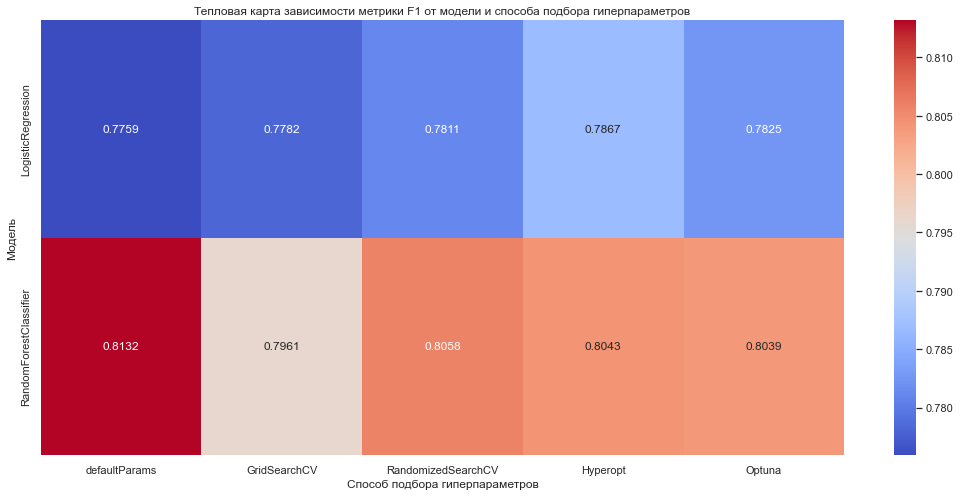

In [74]:
# Построим тепловую карту с сохраненными метриками
metrics_results_df = pd.DataFrame(metrics_results)
metrics_results_df = metrics_results_df.set_index('model')
sns.heatmap(metrics_results_df, annot=True, cmap='coolwarm', fmt ='.4g')
plt.title('Тепловая карта зависимости метрики F1 от модели и способа подбора гиперпараметров')
plt.xlabel('Cпособ подбора гиперпараметров')
plt.ylabel('Модель')

По графику видно, что модель случайный лес показывает более хорошие результаты, чем логигистическая регрессия.

Наилучший результат показала модель случайный лес с параметрами по умолчанию.\
Но эта модель была переобучена (на тренировочной выборке $F_1$ = 1).

Следующий результат у модели случайный лес со способом подбора гиперпараметров через **RandomizedSearchCV**.\
Там у тренировочной выборки метрика $F_1$ была равна 0.82\
То есть, практически равна $F_1$ на тестовой выборке.

Поэтому лучшим результатом тут можно считать модель случайный лес и способ подбора гиперпараметров через **RandomizedSearchCV**.

In [63]:
# Завершим эксперимент
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/experiment0/predicting-biological-response/74718b66e9ad4415a2e1ba68b63f2c59
COMET INFO:   Metrics:
COMET INFO:     F1 LogisticRegression GridSearchCV           : 0.7781731909845789
COMET INFO:     F1 LogisticRegression Hyperopt               : 0.7867298578199051
COMET INFO:     F1 LogisticRegression Optuna                 : 0.7825059101654847
COMET INFO:     F1 LogisticRegression RandomizedSearchCV     : 0.7810650887573964
COMET INFO:     F1 LogisticRegression defaultParams          : 0.7759125571008845
COMET INFO:     F1 RandomForestClassifier GridSearchCV       : 0.796116504854369
COMET INFO:     F1 RandomForestClassifier Hype